In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import seaborn as sns
import warnings

#### Load the Dataset

In [44]:

# Load dataset
train_data = pd.read_csv('diabetic_data.csv')

train_data

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,clinical_note
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,NO,Patient [0-10) years old with well-controlled ...
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,Up,No,No,No,No,No,Ch,Yes,>30,Patient [10-20) years old with well-controlled...
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,Yes,NO,Patient [20-30) years old admitted for diabete...
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,Up,No,No,No,No,No,Ch,Yes,NO,Patient [30-40) years old with well-controlled...
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,Steady,No,No,No,No,No,Ch,Yes,NO,Patient [40-50) years old with well-controlled...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,Down,No,No,No,No,No,Ch,Yes,>30,Patient [70-80) years old with well-controlled...
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,Steady,No,No,No,No,No,No,Yes,NO,Patient [80-90) years old with well-controlled...
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,Down,No,No,No,No,No,Ch,Yes,NO,Patient [70-80) years old with well-controlled...
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,Up,No,No,No,No,No,Ch,Yes,NO,Patient [80-90) years old with well-controlled...


#### Preprocessing: 
##### Filling Missing Values and Dropping Column. I replace all NaN values with an empty string and removed irrelevant or not useful for the analysis 

In [45]:
# Preprocessing: Drop unwanted columns and handle missing values
train_data.fillna('', inplace=True)  # Fill missing values in clinical notes
train_data.drop(train_data.columns[[0, 1, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 19, 20, 29, 32, 37, 39, 40, 43, 44, 45, 46]], axis=1, inplace=True)


#### Processing Clinical Notes with TF-IDF

##### Clinical Notes are free-text data, which the model can’t interpret directly in its raw form. The use of TF-IDF (Term Frequency–Inverse Document Frequency) was to transforms text into numerical features.

In [46]:
# Process Clinical Notes with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Limiting to top 100 words for simplicity
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['clinical_note'])
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1324838 stored elements and shape (101766, 32)>

#### Converting TF-IDF Matrix to a DataFrame
##### Once the text is transformed into TF-IDF scores, i converted it to a DataFrame to easily merge these features with the rest of our dataset.

In [47]:
# Convert the TF-IDF matrix into a DataFrame
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_features

,10,100,11,12,13,14,20,30,40,50,...,management,medication,non,old,patient,showed,stayed,well,with,years
0,0.784675,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.175769,0.175769,0.000000,0.000000,0.223000,0.175769,0.175769
1,0.601365,0.0,0.0,0.0,0.0,0.0,0.642378,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.134707,0.134707,0.000000,0.000000,0.170905,0.134707,0.134707
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.497096,0.409689,0.000000,0.000000,...,0.254915,0.254915,0.254915,0.104242,0.104242,0.254915,0.254915,0.000000,0.104242,0.104242
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.645921,0.496807,0.000000,...,0.000000,0.000000,0.000000,0.164348,0.164348,0.000000,0.000000,0.208511,0.164348,0.164348
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.581749,0.448211,...,0.000000,0.000000,0.000000,0.192448,0.192448,0.000000,0.000000,0.244161,0.192448,0.192448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.229970,0.229970,0.000000,0.000000,0.291766,0.229970,0.229970
101762,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.209501,0.209501,0.000000,0.000000,0.265796,0.209501,0.209501
101763,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.229970,0.229970,0.000000,0.000000,0.291766,0.229970,0.229970
101764,0.683070,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.153009,0.153009,0.000000,0.000000,0.194125,0.153009,0.153009


#### Encoding Categorical Columns Using OneHotEncoder
##### Here i converted Categorical Variables (e.g., race, gender, medication names) into numeric format for the machine learning algorithms to work.

In [48]:
# Encode categorical columns using OneHotEncoder
categorical_cols = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
                    'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
                    'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin', 
                    'change', 'diabetesMed']

# Apply OneHotEncoder to categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')
categorical_encoded = ohe.fit_transform(train_data[categorical_cols]).toarray()
categorical_df = pd.DataFrame(categorical_encoded, columns=ohe.get_feature_names_out(categorical_cols))



#### Combining Structured Features with TF-IDF Features: 
##### Our dataset includes structured numeric data (like time_in_hospital), categorical data (converted into one-hot columns), and text-derived TF-IDF data, so by concatenating them, we create one comprehensive feature set that captures all relevant information for the model.


In [49]:
# Combine the structured features and TF-IDF features
structured_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
structured_df = train_data[structured_features]

# Concatenate all features
final_data = pd.concat([structured_df, categorical_df, tfidf_features], axis=1)



#### Preparing the Target Variable
##### In this step, i structured the target varibale into readmitted '<30', '>30', or 'NO'. this defined what the model is predicting as
##### '<30' → 1 (positive class: readmitted within 30 days)
##### '>30'and'NO'→ 0

In [50]:
# Convert the target variable 'readmitted' into binary labels
train_labels = train_data['readmitted'].map({'<30': 1, '>30': 0, 'NO': 0})

train_labels.head(17)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    1
13    0
14    0
15    0
16    1
Name: readmitted, dtype: int64

#### Splitting the Data into Training and Validation Sets
##### Here the data is splited into 80% training data and 20% validation dataset. the 20% of the data was reserved for validation to gauge how well the model generalizes to unseen data.

In [51]:
# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(final_data, train_labels, test_size=0.2, random_state=0)


#### Training the Random Forest Classifier


In [52]:
# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=25, random_state=0)
rf_classifier.fit(X_train, y_train)




RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=1000,
                       random_state=0)

#### Evaluating the Model

In [53]:
# Evaluate the model
train_accuracy = rf_classifier.score(X_train, y_train)
valid_accuracy = rf_classifier.score(X_valid, y_valid)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {valid_accuracy}")

Training Accuracy: 0.9212646784257849
Validation Accuracy: 0.8895548786479316


#### Top important features in the model

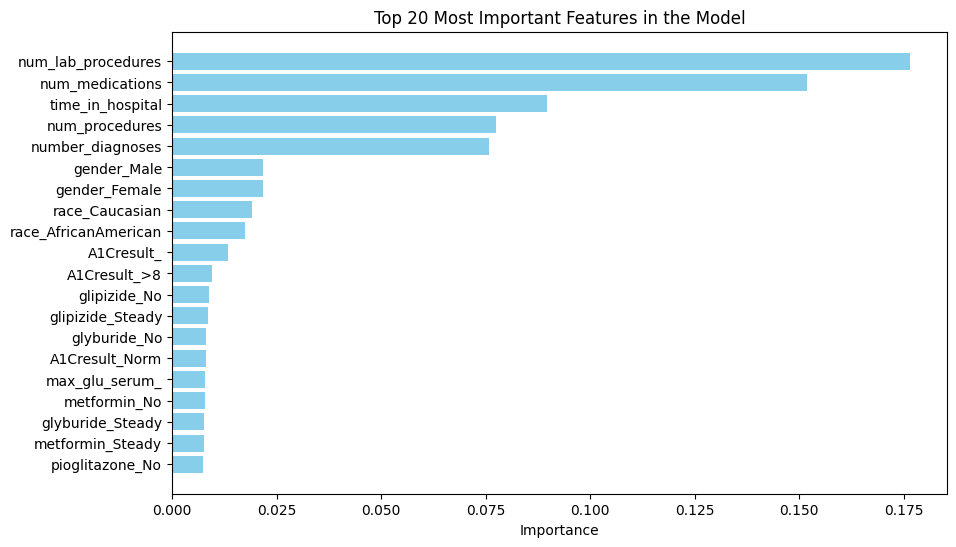

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the feature importances from the trained random forest model
feature_importances = rf_classifier.feature_importances_

# Get the feature names (columns) used in the model
feature_names = final_data.columns

# Create a DataFrame to combine feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_20_features = feature_importance_df.head(20)

# Plot the top 10 most important features using a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features in the Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()


#### 2. Testing the model with unseen dataset.


#### Loading the Test Dataset

In [55]:

# Load the test dataset
test_data = pd.read_csv('diabetic_data_test.csv')
test_data



,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,clinical_note
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,Patient [0-10) years old with well-controlled ...
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,Patient [10-20) years old with well-controlled...
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,Patient [20-30) years old admitted for diabete...
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,Patient [30-40) years old with well-controlled...
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,Patient [40-50) years old with well-controlled...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,Patient [70-80) years old with well-controlled...
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,Patient [80-90) years old with well-controlled...
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,Patient [70-80) years old with well-controlled...
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,Patient [80-90) years old with well-controlled...


Filling Missing Values.

In [56]:
# Fill missing values in the 'clinical_note' column
test_data.fillna('', inplace=True)


#### Dropping Unwanted Columns

In [57]:
# Preprocessing the test dataset: drop unwanted columns and encode categorical columns
test_data.drop(test_data.columns[[0, 1, 5, 6, 7, 8, 10, 11, 15, 16, 17, 18, 19, 20, 29, 32, 37, 39, 40, 43, 44, 45, 46]], axis=1, inplace=True)


Processing Clinical Notes with TF-IDF

In [58]:
# Process Clinical Notes with TF-IDF (using the same vectorizer as in the training set)
tfidf_vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix_test = tfidf_vectorizer.fit_transform(test_data['clinical_note'])
tfidf_features_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


#### Encoding Categorical Columns

In [59]:
# Encode categorical columns in the test data using the same OneHotEncoder as in the training set
categorical_cols_test = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
                         'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
                         'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide-metformin', 
                         'change', 'diabetesMed']

# Assuming the OneHotEncoder has already been fit on the training data
ohe = OneHotEncoder(handle_unknown='ignore')
categorical_encoded_test = ohe.fit_transform(test_data[categorical_cols_test]).toarray()
categorical_df_test = pd.DataFrame(categorical_encoded_test, columns=ohe.get_feature_names_out(categorical_cols_test))


#### Selecting Structured Features

In [60]:
# Structured features in the test dataset (same as in the training data)
structured_features_test = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']
structured_df_test = test_data[structured_features_test]



#### Combining All Test Features

In [61]:
# Combine the structured features, categorical features, and TF-IDF features for the test data
final_data_test = pd.concat([structured_df_test, categorical_df_test, tfidf_features_test], axis=1)


#### Generate Prediction for Test Data

In [62]:
# Use the trained model to generate predictions for the test data

y_test_predicted = rf_classifier.predict(final_data_test)

In [65]:
# Add the predictions to the test data
test_data['readmitted'] = y_test_predicted

# Group by the 'readmitted' column and count the occurrences of each category
readmitted_counts = test_data.groupby('readmitted')['readmitted'].count()
print(readmitted_counts)

readmitted
0    99047
1     2719
Name: readmitted, dtype: int64
